In [8]:
import cv2
import h5py
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.ndimage import binary_fill_holes
from scipy.special import ellipe
from PIL import Image

pd.set_option('display.max_columns', 100)

In [63]:
PATH_TO_HOVERNET_OUT = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/hovernet_out"
PATH_TO_SAMPLE_PATCH = os.path.join(PATH_TO_HOVERNET_OUT, "tma5-E0683B_v1-39")
PATH_TO_SAMPLE_PATCH_SEG_MAP = os.path.join(PATH_TO_SAMPLE_PATCH, "instances.npy")
PATH_TO_SAMPLE_PATCH_IMAGE = os.path.join(PATH_TO_SAMPLE_PATCH, "overlay.png")
PATH_TO_SAMPLE_PATCH_INSTANCE_DICT = os.path.join(PATH_TO_SAMPLE_PATCH, "nuclei_dict.json")

PATH_TO_OUTPUT_CELLS = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells"
PATH_TO_OUTPUT_CELL_FEATURES = os.path.join(PATH_TO_OUTPUT_CELLS, "cell_shapes_features_v1")
PATH_TO_CELLS_HDF5 = os.path.join(PATH_TO_OUTPUT_CELLS, "cells.hdf5")
PATH_TO_AGG_GEO_FEATURES = os.path.join(PATH_TO_OUTPUT_CELLS, "geometric_features")

PATH_TO_DATA_SPLITS = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/data_splits"
PATH_TO_TRANSCRIPTION_SPLITS_OUTPUT = os.path.join(PATH_TO_DATA_SPLITS, "transcription_splits/dlbcl-morph")

## Inspect Data in Hovernet Output Directory

In [10]:
num_patches = len(os.listdir(PATH_TO_HOVERNET_OUT))
print(f"Number of patches extracted by HoVer-Net: {num_patches}")

Number of patches extracted by HoVer-Net: 138386


(224, 224)


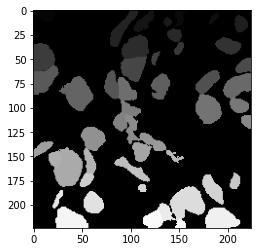

In [11]:
seg_map = np.load(PATH_TO_SAMPLE_PATCH_SEG_MAP)
image = Image.open(PATH_TO_SAMPLE_PATCH_IMAGE)
print(seg_map.shape)
plt.imshow(seg_map, cmap="gray")

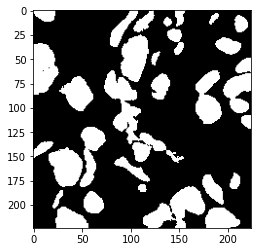

In [12]:
binary_seg_mask = seg_map.copy()
binary_seg_mask[binary_seg_mask > 0] = 1
plt.imshow(binary_seg_mask, cmap="gray")

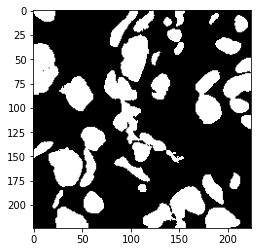

In [13]:
gray_scale_image = seg_map.copy()
gray_scale_image[gray_scale_image > 0] = 255
gray_scale_image = np.stack((gray_scale_image,)*3, axis=-1)
plt.imshow(gray_scale_image)

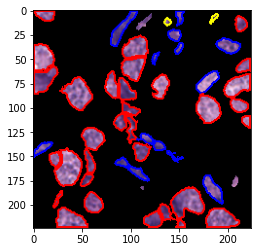

In [14]:
plt.imshow(image * np.stack((binary_seg_mask,)*3, axis=-1))

In [15]:
cell_nums = set(seg_map.flatten())
print(cell_nums)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}


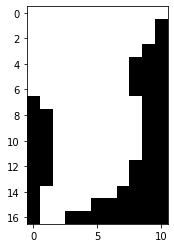

In [16]:
def crop_im(im):
    arg_ones = np.argwhere(im) # shape: (pixels_of_ones, 2)
    row_min, col_min = np.amin(arg_ones, axis=0)
    row_max, col_max = np.amax(arg_ones, axis=0)
    
    return im[row_min:row_max+1, col_min:col_max+1]

cell_id = 2
cell_mask = (seg_map == cell_id)
im_cell = crop_im(cell_mask)
plt.imshow(im_cell, cmap='gray')

In [17]:
with open(PATH_TO_SAMPLE_PATCH_INSTANCE_DICT) as json_file:
    data = json.load(json_file)
    cell_type = data['2']['type']
    contours = data['2']['contour']
print(f"Cell type: {cell_type}")
print(contours)

Cell type: 3
[[146, 0], [146, 6], [148, 8], [148, 13], [147, 14], [147, 16], [148, 16], [149, 15], [150, 15], [151, 14], [152, 14], [153, 13], [153, 12], [154, 11], [154, 7], [153, 6], [153, 4], [155, 2], [155, 1], [156, 0]]


## Load and visualize nucleus segmentation mask

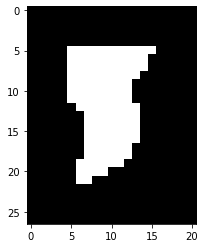

In [18]:
img = np.pad(im_cell, 5) 
img = binary_fill_holes(img) #fill holes that sometimes appear inside the segmentation mask

mask = img.copy()
img = img.astype(np.uint8)
img[mask] = 255
plt.imshow(img, cmap='gray')
plt.show()

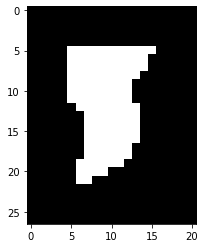

In [19]:
ret, thresh = cv2.threshold(img,127,255,0)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

plt.imshow(thresh, cmap='gray')
plt.show()

## Fit rectangle

Rectangle center: (10.0, 13.0)
Rectangle width: 16.000000, height: 10.000000
Rectangle rotation angle: 90.0


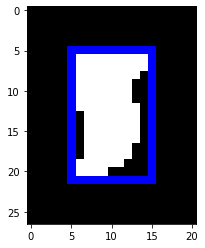

In [20]:
rect = cv2.minAreaRect(cnt)
(rectCoord1, rectCoord2, rotate_angle) = rect
box = cv2.boxPoints(rect)
box = np.int0(box)

rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img,[box],0,(0,0,255),1)
plt.imshow(rgb_img)

print("Rectangle center:", rect[0])
print("Rectangle width: %.6f, height: %.6f" % (rect[1][0], rect[1][1]))
print("Rectangle rotation angle:", rect[2])

## Fit ellipse

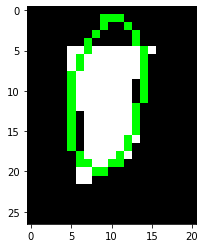

In [21]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

ellipse = cv2.fitEllipseDirect(cnt)  #(x, y), (major, minor), angle                                                            
ell = cv2.ellipse(rgb_img,ellipse,(0,255,0),1)
(ellpCtr_x, ellpCtr_y), (shortAxis, longAxis), angle = ellipse
plt.imshow(rgb_img)

In [22]:
# perimeter and area of ellipse                                                                                                            
a = longAxis / 2
b = shortAxis / 2
e = np.sqrt(1 - b**2 / a**2)  # eccentricity                                                                                       
perimt = 4 * a * ellipe(e*e)
area = np.pi * a * b

In [23]:
print("Ellipse centroid:", (ellpCtr_x, ellpCtr_y))
print("Major axis (longAxis) length: %.6f" % longAxis)
print("Minor axis (shortAxis) length: %.6f" % shortAxis)
print("Ellipse parimeter: %.6f" % perimt)
print("Ellipse area: %.6f" % area)

Ellipse centroid: (9.303385734558105, 10.593705177307129)
Major axis (longAxis) length: 19.193127
Minor axis (shortAxis) length: 8.881088
Ellipse parimeter: 45.599310
Ellipse area: 133.875713


## Convex hull area

In [24]:
hull = cv2.convexHull(cnt)
hull_area = cv2.contourArea(hull)
print("Convex hull area: %.6f" % hull_area)

Convex hull area: 123.500000


## Get Number of Cells Extracted

In [27]:
cell_hdf5_files = glob.glob(os.path.join(PATH_TO_OUTPUT_CELLS, "tma*_cells.hdf5"))
cell_shapes_files = glob.glob(os.path.join(PATH_TO_OUTPUT_CELL_FEATURES, "tma*_cell_shapes.csv"))

In [28]:
def get_tma_id_from_filename(filename):
    return filename.split("/")[-1].split("_")[0]

cell_shapes_files

['/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma5_cell_shapes.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma4_cell_shapes.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma8_cell_shapes.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma6a_cell_shapes.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma1_cell_shapes.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma6b_cell_shapes.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma2_cell_shapes.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_shapes_features_v1/tma3_cell_shapes.csv']

In [29]:
cell_hdf5_map = {get_tma_id_from_filename(filename) : h5py.File(filename, "r") for filename in cell_hdf5_files}
cell_shapes_df_map = {get_tma_id_from_filename(filename) : pd.read_csv(filename) for filename in cell_shapes_files}

In [30]:
print(len(cell_shapes_df_map.keys()))

8


In [31]:
tma1_df = cell_shapes_df_map['tma1']
tma1_df.head()

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,hull_area,hull_perimeter,min_diameter,max_diameter,min_angle,max_angle,esf,csf,sf1,sf2,elongation,convexity,compactness,cell_type
0,0,tma1,E0002B_v1,0,1,26.565050,15.060187,18.662271,53.122317,220.741891,7.800000,9.900000,15.652474,17.888544,7.903851,10.144740,231.0,62.647031,16.898276,21.095023,-158.198591,-95.440332,0.806986,0.982971,0.713921,0.801055,1.248354,0.977544,50.067159,1
1,1,tma1,E0002B_v1,0,2,12.528809,15.807603,16.977793,51.515582,210.783750,8.905882,7.423531,17.137506,15.402064,8.768550,8.256520,217.0,62.647031,16.595180,20.248457,-77.471192,-122.905243,0.931075,0.998090,0.780682,0.819578,1.220141,0.985573,48.786829,2
2,2,tma1,E0002B_v1,0,3,45.000000,10.140018,11.546165,34.100389,91.953090,4.750000,5.250000,9.899494,10.606602,4.993966,5.515516,89.0,62.647031,11.313708,13.000000,45.000000,157.380135,0.878215,0.993705,0.780001,0.870285,1.149049,1.016455,33.536112,2
3,3,tma1,E0002B_v1,0,4,39.805569,13.411483,14.622210,44.055757,154.020909,5.409836,9.508198,13.315837,14.084057,5.501787,8.762449,147.5,62.647031,14.000000,17.262677,0.000000,100.007980,0.917199,0.997204,0.776906,0.810998,1.233048,1.021866,42.728058,2
4,4,tma1,E0002B_v1,0,5,38.659809,21.966085,22.973110,70.599185,396.334926,10.207318,11.865853,21.395805,21.708153,10.932357,12.005103,395.0,62.647031,22.627417,25.709920,45.000000,-103.495733,0.956165,0.999247,0.854382,0.880105,1.136229,1.001688,68.878800,1


In [32]:
num_cells = sum([cell_shape_df.shape[0] for (tma_id, cell_shape_df) in cell_shapes_df_map.items()])
print(f"Total number of extracted cells: {num_cells}")

Total number of extracted cells: 7997643


## Inspect an individual cell in the cells HDF5 file

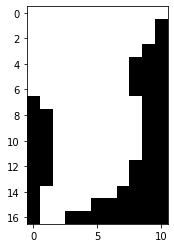

In [33]:
tma_id = "tma5"
patient_id = "E0683B_v1"
patch_id = "39"
cell_id = "2"

tma5_file = cell_hdf5_map[tma_id]
cell_data = tma5_file[tma_id][patient_id][patch_id][cell_id][cell_id]
cell_npy = np.zeros(cell_data.shape)
cell_data.read_direct(cell_npy)
plt.imshow(cell_npy, cmap='gray')

In [34]:
img = binary_fill_holes(cell_npy)
mask = img.copy()
img = img.astype(np.uint8)
img[mask] = 255

ret, thresh = cv2.threshold(img, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

Rectangle center: (5.0, 8.0)
Rectangle width: 16.000000, height: 10.000000
Rectangle rotation angle: 90.0


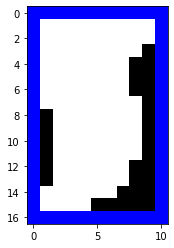

In [35]:
rect = cv2.minAreaRect(cnt)
(rectCoord1, rectCoord2, rotate_angle) = rect
box = cv2.boxPoints(rect)
box = np.int0(box)

rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img,[box],0,(0,0,255),1)
plt.imshow(rgb_img)

print("Rectangle center:", rect[0])
print("Rectangle width: %.6f, height: %.6f" % (rect[1][0], rect[1][1]))
print("Rectangle rotation angle:", rect[2])

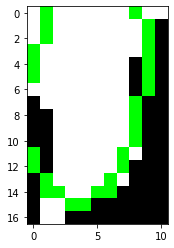

In [36]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

ellipse = cv2.fitEllipseDirect(cnt)  #(x, y), (major, minor), angle                                                            
ell = cv2.ellipse(rgb_img,ellipse,(0,255,0),1)
(ellpCtr_x, ellpCtr_y), (shortAxis, longAxis), angle = ellipse
plt.imshow(rgb_img)

In [37]:
# perimeter and area of ellipse                                                                                                            
a = longAxis / 2
b = shortAxis / 2
e = np.sqrt(1 - b**2 / a**2)  # eccentricity                                                                                       
perimt = 4 * a * ellipe(e*e)
area = np.pi * a * b

In [38]:
print("Ellipse centroid:", (ellpCtr_x, ellpCtr_y))
print("Major axis (longAxis) length: %.6f" % longAxis)
print("Minor axis (shortAxis) length: %.6f" % shortAxis)
print("Ellipse parimeter: %.6f" % perimt)
print("Ellipse area: %.6f" % area)

Ellipse centroid: (4.3033857345581055, 5.593704700469971)
Major axis (longAxis) length: 19.193127
Minor axis (shortAxis) length: 8.881088
Ellipse parimeter: 45.599310
Ellipse area: 133.875713


## Get Geometric Features for Cell

In [39]:
tma5_df = cell_shapes_df_map[tma_id]
tma5_df.head()

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,hull_area,hull_perimeter,min_diameter,max_diameter,min_angle,max_angle,esf,csf,sf1,sf2,elongation,convexity,compactness,cell_type
0,0,tma5,E0486B_v1,0,1,90.000000,13.798190,26.200121,64.348569,283.932628,12.000000,7.500000,15.000000,24.000000,11.837361,7.053302,290.0,81.481586,15.173104,27.784888,-105.255119,149.743563,0.526646,0.861683,0.496608,0.546092,1.831193,0.989484,54.189281,1
1,1,tma5,E0486B_v1,0,10,90.000000,14.680865,18.534990,52.351109,213.714455,10.000000,7.000000,14.000000,20.000000,10.760929,5.780444,224.5,81.481586,15.000000,22.803509,-90.000000,-142.125016,0.792062,0.979923,0.643799,0.657794,1.520234,0.975683,45.908227,2
2,2,tma5,E0486B_v1,0,11,16.699244,10.586707,17.642282,45.037256,146.691703,5.793578,10.188074,11.206569,18.486048,5.550933,10.026292,158.5,81.481586,12.451742,20.223748,16.699244,-98.530766,0.600076,0.908807,0.523479,0.615699,1.624170,0.962029,37.769167,2
3,3,tma5,E0486B_v1,0,12,39.805569,5.002738,9.556414,23.432272,37.548495,4.778688,4.565574,5.505586,9.858840,4.759400,3.699540,34.5,81.481586,6.913992,11.313708,39.805571,135.000000,0.523495,0.859357,0.442184,0.611116,1.636350,1.043246,19.352794,0
4,4,tma5,E0486B_v1,0,13,90.000000,16.570950,17.068466,52.843560,222.142560,8.500000,8.000000,16.000000,17.000000,8.700495,8.646334,222.0,81.481586,17.000000,19.313208,-90.000000,-158.749494,0.970852,0.999672,0.858011,0.880227,1.136071,1.000321,51.869160,2


In [40]:
tma5_df[(tma5_df["tma_id"] == tma_id) & 
        (tma5_df["patient_id"] == patient_id) & 
        (tma5_df["patch_id"] == int(patch_id)) & 
        (tma5_df["cell_id"] == int(cell_id))]

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,hull_area,hull_perimeter,min_diameter,max_diameter,min_angle,max_angle,esf,csf,sf1,sf2,elongation,convexity,compactness,cell_type
1607386,1607386,tma5,E0683B_v1,39,2,90.0,8.881088,19.193127,45.59931,133.875713,5.0,8.0,16.0,10.0,4.303386,5.593705,123.5,81.481586,11.0,19.723083,0.0,120.465545,0.462722,0.809087,0.450289,0.557722,1.793008,1.04116,36.294202,3


## Aggregate Features Across All Patches + Cells for Each Patient

In [41]:
NEW_AGG_COLS = ["rotate_angle_mean", "rotate_angle_std",
                "short_axis_mean", "short_axis_std",
                "long_axis_mean", "long_axis_std",
                "ellipse_perim_mean", "ellipse_perim_std",
                "ellipse_area_mean", "ellipse_area_std",
                "rect_center_x_mean", "rect_center_x_std",
                "rect_center_y_mean", "rect_center_y_std",
                "rect_width_mean", "rect_width_std",
                "rect_height_mean", "rect_height_std",
                "ellipse_centroid_x_mean", "ellipse_centroid_x_std",
                "ellipse_centroid_y_mean", "ellipse_centroid_y_std",
                "hull_area_mean", "hull_area_std",
                "hull_perimeter_mean", "hull_perimeter_std",
                "min_diameter_mean", "min_diameter_std",
                "max_diameter_mean", "max_diameter_std",
                "min_angle_mean", "min_angle_std",
                "max_angle_mean", "max_angle_std",
                "esf_mean", "esf_std",
                "csf_mean", "csf_std",
                "sf1_mean", "sf1_std",
                "sf2_mean", "sf2_std",
                "elongation_mean", "elongation_std",
                "convexity_mean", "convexity_std",
                "compactness_mean", "compactness_std"]

print(len(NEW_AGG_COLS))

48


In [42]:
patient_set = set(tma5_df['patient_id'])
print(f"Number of patients: {len(patient_set)}")

Number of patients: 329


In [43]:
tma5_df_copy = tma5_df.copy()
tma5_df_copy = tma5_df_copy.drop(["Unnamed: 0", "patch_id", "cell_id", "cell_type"], axis=1)
tma5_average_df = tma5_df_copy.groupby('patient_id').agg([np.mean, np.std])
display(tma5_average_df.head())

rotate_angle            short_axis            long_axis            \
                   mean        std       mean       std       mean       std   
patient_id                                                                     
E0486B_v1     64.144793  29.401523  14.690523  3.718745  20.579367  5.550408   
E0486B_v2     62.965641  29.264646  14.448850  3.729894  20.466266  5.548653   
E0487B_v1     65.340403  29.129900  13.527377  3.307540  20.458567  5.973727   
E0488C_v1     64.636894  28.274976  15.389257  3.585052  21.078112  4.813439   
E0488C_v2     66.214384  28.267591  15.534112  3.599096  20.973176  4.931117   

           ellipse_perim            ellipse_area             rect_center_x  \
                    mean        std         mean         std          mean   
patient_id                                                                   
E0486B_v1      55.910779  13.725210   248.926887  122.788330      8.419012   
E0486B_v2      55.378499  13.721192   243.701878  123.837189      8.772436   
E0487B_v1      54.117099  13.534627   226.256054  108.027805      9.220606   
E0488C_v1      57.753152  12.156467   263.610893  103.550261      8.966722   
E0488C_v2      57.797530  12.271201   264.547564  105.422089      8.849358   

                     rect_center_y           rect_width           rect_height  \
                 std          mean       std       mean       std        mean   
patient_id                                                                      
E0486B_v1   2.616722      8.982394  2.827810  17.222427  5.682719   17.021286   
E0486B_v2   2.802706      8.535675  2.678563  17.118253  5.688706   16.874992   
E0487B_v1   3.120192      7.626585  2.264529  15.820773  5.606358   17.360149   
E0488C_v1   2.588071      8.925457  2.513463  17.512741  5.148684   17.665880   
E0488C_v2   2.523701      9.010233  2.624995  17.854500  5.428354   17.328434   

                     ellipse_centroid_x           ellipse_centroid_y  \
                 std               mean       std               mean   
patient_id                                                             
E0486B_v1   5.430768           8.427546  2.789665           8.974837   
E0486B_v2   5.398449           8.779149  2.985195           8.545147   
E0487B_v1   6.027464           9.214153  3.281233           7.622259   
E0488C_v1   5.157258           8.982342  2.794451           8.923799   
E0488C_v2   4.953468           8.866411  2.723622           9.018235   

                       hull_area             hull_perimeter      min_diameter  \
                 std        mean         std           mean  std         mean   
patient_id                                                                      
E0486B_v1   3.049831  239.723685  122.645295      81.481586  0.0    15.453003   
E0486B_v2   2.853083  235.467518  123.024918      81.481586  0.0    15.318802   
E0487B_v1   2.355809  220.238964  108.791130      81.481586  0.0    14.482006   
E0488C_v1   2.714706  251.259312  106.964762      81.481586  0.0    16.004301   
E0488C_v2   2.856923  252.141722  108.975550      81.481586  0.0    16.087614   

                     max_diameter            min_angle             max_angle  \
                 std         mean       std       mean        std       mean   
patient_id                                                                     
E0486B_v1   4.088399    22.217808  5.530423 -18.100953  75.664896  11.792609   
E0486B_v2   4.020172    22.118672  5.531324 -19.753098  78.761389  -9.694201   
E0487B_v1   3.549289    21.978559  5.920011 -28.839538  76.138854   8.701898   
E0488C_v1   4.131874    22.615194  4.746892 -20.025771  74.684786   5.993349   
E0488C_v2   4.130111    22.522103  4.900084 -20.102270  74.632909 -12.627437   

                             esf                 csf                 sf1  \
                   std      mean       std      mean       std      mean   
patient_id                                                                 
E

In [44]:
tma5_average_df.columns = tma5_average_df.columns.droplevel(0)
tma5_average_df.columns = NEW_AGG_COLS
tma5_average_df["tma_id"] = "tma5"
display(tma5_average_df.head())

,rotate_angle_mean,rotate_angle_std,short_axis_mean,short_axis_std,long_axis_mean,long_axis_std,ellipse_perim_mean,ellipse_perim_std,ellipse_area_mean,ellipse_area_std,rect_center_x_mean,rect_center_x_std,rect_center_y_mean,rect_center_y_std,rect_width_mean,rect_width_std,rect_height_mean,rect_height_std,ellipse_centroid_x_mean,ellipse_centroid_x_std,ellipse_centroid_y_mean,ellipse_centroid_y_std,hull_area_mean,hull_area_std,hull_perimeter_mean,hull_perimeter_std,min_diameter_mean,min_diameter_std,max_diameter_mean,max_diameter_std,min_angle_mean,min_angle_std,max_angle_mean,max_angle_std,esf_mean,esf_std,csf_mean,csf_std,sf1_mean,sf1_std,sf2_mean,sf2_std,elongation_mean,elongation_std,convexity_mean,convexity_std,compactness_mean,compactness_std,tma_id
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
E0486B_v1,64.144793,29.401523,14.690523,3.718745,20.579367,5.550408,55.910779,13.725210,248.926887,122.788330,8.419012,2.616722,8.982394,2.827810,17.222427,5.682719,17.021286,5.430768,8.427546,2.789665,8.974837,3.049831,239.723685,122.645295,81.481586,0.0,15.453003,4.088399,22.217808,5.530423,-18.100953,75.664896,11.792609,131.603488,0.727828,0.130733,0.948403,0.055150,0.669358,0.114736,0.701766,0.125844,1.484670,0.351380,1.033368,0.106982,52.404974,13.547420,tma5
E0486B_v2,62.965641,29.264646,14.448850,3.729894,20.466266,5.548653,55.378499,13.721192,243.701878,123.837189,8.772436,2.802706,8.535675,2.678563,17.118253,5.688706,16.874992,5.398449,8.779149,2.985195,8.545147,2.853083,235.467518,123.024918,81.481586,0.0,15.318802,4.020172,22.118672,5.531324,-19.753098,78.761389,-9.694201,138.459330,0.720410,0.132394,0.945421,0.057600,0.661556,0.115227,0.699856,0.122105,1.484700,0.338580,1.029157,0.104181,51.628277,13.618124,tma5
E0487B_v1,65.340403,29.129900,13.527377,3.307540,20.458567,5.973727,54.117099,13.534627,226.256054,108.027805,9.220606,3.120192,7.626585,2.264529,15.820773,5.606358,17.360149,6.027464,9.214153,3.281233,7.622259,2.355809,220.238964,108.791130,81.481586,0.0,14.482006,3.549289,21.978559,5.920011,-28.839538,76.138854,8.701898,147.125860,0.685156,0.148175,0.927304,0.075517,0.631854,0.128933,0.674509,0.131339,1.553756,0.385304,1.023540,0.093225,49.309025,12.242685,tma5
E0488C_v1,64.636894,28.274976,15.389257,3.585052,21.078112,4.813439,57.753152,12.156467,263.610893,103.550261,8.966722,2.588071,8.925457,2.513463,17.512741,5.148684,17.665880,5.157258,8.982342,2.794451,8.923799,2.714706,251.259312,106.964762,81.481586,0.0,16.004301,4.131874,22.615194,4.746892,-20.025771,74.684786,5.993349,137.384714,0.739630,0.130589,0.952222,0.054755,0.685129,0.114060,0.709270,0.131971,1.476969,0.383880,1.042735,0.117625,54.842784,12.508890,tma5
E0488C_v2,66.214384,28.267591,15.534112,3.599096,20.973176,4.931117,57.797530,12.271201,264.547564,105.422089,8.849358,2.523701,9.010233,2.624995,17.854500,5.428354,17.328434,4.953468,8.866411,2.723622,9.018235,2.856923,252.141722,108.975550,81.481586,0.0,16.087614,4.130111,22.522103,4.900084,-20.102270,74.632909,-12.627437,134.924392,0.752050,0.134770,0.954903,0.057454,0.696175,0.118475,0.717869,0.136391,1.462211,0.383770,1.042154,0.116182,55.043616,12.501718,tma5


In [47]:
def aggregate_geo_features(cell_shapes_df_map):
    for tma_id in cell_shapes_df_map:
        print(tma_id)
        tma_df = cell_shapes_df_map[tma_id]
        patient_set = set(tma_df['patient_id'])
        print(f"Number of patients: {len(patient_set)}")
        tma_df_copy = tma_df.copy()
        tma_df_copy = tma_df_copy.drop(["Unnamed: 0", "patch_id", "cell_id", "cell_type"], axis=1)
        tma_average_df = tma_df_copy.groupby('patient_id').agg([np.mean, np.std])
        tma_average_df.columns = tma_average_df.columns.droplevel(0)
        tma_average_df.columns = NEW_AGG_COLS
        tma_average_df["tma_id"] = tma_id
        print(f"Number of rows in aggregated df: {tma_average_df.shape[0]}")
        tma_average_df.to_csv(os.path.join(PATH_TO_AGG_GEO_FEATURES, f"{tma_id}_geo_features.csv"))
    print("Done!")

aggregate_geo_features(cell_shapes_df_map)

tma5
Number of patients: 329
Number of rows in aggregated df: 329
tma4
Number of patients: 164
Number of rows in aggregated df: 164
tma8
Number of patients: 48
Number of rows in aggregated df: 48
tma6a
Number of patients: 205
Number of rows in aggregated df: 205
tma1
Number of patients: 155
Number of rows in aggregated df: 155
tma6b
Number of patients: 172
Number of rows in aggregated df: 172
tma2
Number of patients: 251
Number of rows in aggregated df: 251
tma3
Number of patients: 126
Number of rows in aggregated df: 126
Done!


In [48]:
tma5_geo_features_df = pd.read_csv(os.path.join(PATH_TO_AGG_GEO_FEATURES, f"{tma_id}_geo_features.csv"))
tma5_geo_features_df.head()

,patient_id,rotate_angle_mean,rotate_angle_std,short_axis_mean,short_axis_std,long_axis_mean,long_axis_std,ellipse_perim_mean,ellipse_perim_std,ellipse_area_mean,ellipse_area_std,rect_center_x_mean,rect_center_x_std,rect_center_y_mean,rect_center_y_std,rect_width_mean,rect_width_std,rect_height_mean,rect_height_std,ellipse_centroid_x_mean,ellipse_centroid_x_std,ellipse_centroid_y_mean,ellipse_centroid_y_std,hull_area_mean,hull_area_std,hull_perimeter_mean,hull_perimeter_std,min_diameter_mean,min_diameter_std,max_diameter_mean,max_diameter_std,min_angle_mean,min_angle_std,max_angle_mean,max_angle_std,esf_mean,esf_std,csf_mean,csf_std,sf1_mean,sf1_std,sf2_mean,sf2_std,elongation_mean,elongation_std,convexity_mean,convexity_std,compactness_mean,compactness_std,tma_id
0,E0486B_v1,64.144793,29.401523,14.690523,3.718745,20.579367,5.550408,55.910779,13.725210,248.926887,122.788330,8.419012,2.616722,8.982394,2.827810,17.222427,5.682719,17.021286,5.430768,8.427546,2.789665,8.974837,3.049831,239.723685,122.645295,81.481586,0.0,15.453003,4.088399,22.217808,5.530423,-18.100953,75.664896,11.792609,131.603488,0.727828,0.130733,0.948403,0.055150,0.669358,0.114736,0.701766,0.125844,1.484670,0.351380,1.033368,0.106982,52.404974,13.547420,tma5
1,E0486B_v2,62.965641,29.264646,14.448850,3.729894,20.466266,5.548653,55.378499,13.721192,243.701878,123.837189,8.772436,2.802706,8.535675,2.678563,17.118253,5.688706,16.874992,5.398449,8.779149,2.985195,8.545147,2.853083,235.467518,123.024918,81.481586,0.0,15.318802,4.020172,22.118672,5.531324,-19.753098,78.761389,-9.694201,138.459330,0.720410,0.132394,0.945421,0.057600,0.661556,0.115227,0.699856,0.122105,1.484700,0.338580,1.029157,0.104181,51.628277,13.618124,tma5
2,E0487B_v1,65.340403,29.129900,13.527377,3.307540,20.458567,5.973727,54.117099,13.534627,226.256054,108.027805,9.220606,3.120192,7.626585,2.264529,15.820773,5.606358,17.360149,6.027464,9.214153,3.281233,7.622259,2.355809,220.238964,108.791130,81.481586,0.0,14.482006,3.549289,21.978559,5.920011,-28.839538,76.138854,8.701898,147.125860,0.685156,0.148175,0.927304,0.075517,0.631854,0.128933,0.674509,0.131339,1.553756,0.385304,1.023540,0.093225,49.309025,12.242685,tma5
3,E0488C_v1,64.636894,28.274976,15.389257,3.585052,21.078112,4.813439,57.753152,12.156467,263.610893,103.550261,8.966722,2.588071,8.925457,2.513463,17.512741,5.148684,17.665880,5.157258,8.982342,2.794451,8.923799,2.714706,251.259312,106.964762,81.481586,0.0,16.004301,4.131874,22.615194,4.746892,-20.025771,74.684786,5.993349,137.384714,0.739630,0.130589,0.952222,0.054755,0.685129,0.114060,0.709270,0.131971,1.476969,0.383880,1.042735,0.117625,54.842784,12.508890,tma5
4,E0488C_v2,66.214384,28.267591,15.534112,3.599096,20.973176,4.931117,57.797530,12.271201,264.547564,105.422089,8.849358,2.523701,9.010233,2.624995,17.854500,5.428354,17.328434,4.953468,8.866411,2.723622,9.018235,2.856923,252.141722,108.975550,81.481586,0.0,16.087614,4.130111,22.522103,4.900084,-20.102270,74.632909,-12.627437,134.924392,0.752050,0.134770,0.954903,0.057454,0.696175,0.118475,0.717869,0.136391,1.462211,0.383770,1.042154,0.116182,55.043616,12.501718,tma5


## Create Train/Test Splits

In [49]:
PATH_TO_RAW_DATA = "/deep/group/aihc-bootcamp-fall2021/lymphoma/raw"
PATH_TO_TRAIN_TEST_SPLIT = os.path.join(PATH_TO_RAW_DATA, "train_test_split.csv")
PATH_TO_DIAGNOSES = os.path.join(PATH_TO_RAW_DATA, "core_labels.csv")
TMA_ID = "TMA ID"
CASE = "CASE"
LABEL = "label"

In [50]:
data_split_df = pd.read_csv(PATH_TO_TRAIN_TEST_SPLIT, delimiter=',')
data_split_map = data_split_df.set_index('case')['split'].to_dict()

In [51]:
data_split_df.head()

,Unnamed: 0,case,diag,split
0,0,E0087,AGG_BCL,test
1,1,E0107,AGG_BCL,train
2,2,E0129,AGG_BCL,train
3,3,E0228,AGG_BCL,train
4,4,E0570,AGG_BCL,train


In [52]:
cell_features_files = glob.glob(os.path.join(PATH_TO_AGG_GEO_FEATURES, "tma*_geo_features.csv"))
cell_features_files

['/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma1_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma2_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma3_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma5_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma4_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma6b_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma8_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma6a_geo_features.csv']

In [53]:
for filename in cell_features_files:
    tma_id = filename.split("/")[-1].split("_")[0]
    
cell_features_df = pd.concat(pd.read_csv(filename) for filename in cell_features_files)

In [54]:
cell_features_df.head()

,patient_id,rotate_angle_mean,rotate_angle_std,short_axis_mean,short_axis_std,long_axis_mean,long_axis_std,ellipse_perim_mean,ellipse_perim_std,ellipse_area_mean,ellipse_area_std,rect_center_x_mean,rect_center_x_std,rect_center_y_mean,rect_center_y_std,rect_width_mean,rect_width_std,rect_height_mean,rect_height_std,ellipse_centroid_x_mean,ellipse_centroid_x_std,ellipse_centroid_y_mean,ellipse_centroid_y_std,hull_area_mean,hull_area_std,hull_perimeter_mean,hull_perimeter_std,min_diameter_mean,min_diameter_std,max_diameter_mean,max_diameter_std,min_angle_mean,min_angle_std,max_angle_mean,max_angle_std,esf_mean,esf_std,csf_mean,csf_std,sf1_mean,sf1_std,sf2_mean,sf2_std,elongation_mean,elongation_std,convexity_mean,convexity_std,compactness_mean,compactness_std,tma_id
0,E0002B_v1,60.323597,27.547878,12.448914,4.013320,21.786889,9.026695,55.109441,19.468268,228.210964,156.523948,8.781919,3.675104,8.541738,3.700834,14.579767,5.960075,18.930388,9.354261,8.742875,3.885453,8.505244,3.856707,222.862469,152.246132,62.647031,0.0,13.651533,3.915142,23.104977,8.889702,-24.389743,79.073520,42.112941,131.208976,0.618567,0.181285,0.882004,0.118590,0.573790,0.158320,0.629384,0.154976,1.714294,0.540557,1.016782,0.085733,47.155455,16.104116,tma1
1,E0002B_v2,58.057041,28.678615,11.856901,4.272486,20.272325,8.149164,51.613554,18.464187,205.284432,151.436691,8.391598,3.721000,8.087053,3.484219,17.732783,8.651815,14.151123,6.251357,8.392381,3.739000,8.099750,3.587712,203.485493,149.278776,62.647031,0.0,13.125446,4.290879,22.034746,8.341605,-12.228300,81.524067,-50.893987,128.361589,0.622342,0.174768,0.886905,0.111312,0.565584,0.152091,0.626257,0.148957,1.712526,0.517161,1.011645,0.081418,44.017135,15.699586,tma1
2,E0003B_v1,65.479404,28.351476,14.658463,3.913338,20.616875,5.843245,55.935728,14.487217,250.232912,130.401012,8.522343,2.679239,8.749591,2.855900,17.184023,5.788497,16.860648,5.606238,8.524293,2.835071,8.753660,3.089349,238.483634,129.178251,62.647031,0.0,15.348902,4.171147,22.055064,5.713631,-19.800856,74.265165,-3.634835,135.189812,0.726219,0.133253,0.947230,0.056962,0.673085,0.116801,0.703827,0.125366,1.478856,0.344478,1.036475,0.107913,52.770871,14.388827,tma1
3,E0003B_v2,64.975842,28.813238,14.201668,3.946656,20.538415,6.201664,55.175246,15.045258,242.396513,136.626203,8.458890,2.838445,8.620581,2.908742,16.888511,5.981721,16.749368,5.922709,8.482344,3.031775,8.616653,3.093780,232.137293,131.610592,62.647031,0.0,14.997251,4.137206,21.992534,6.084632,-19.371497,75.465233,-1.368772,135.746912,0.710166,0.140773,0.939460,0.065199,0.657266,0.123350,0.692943,0.127822,1.505630,0.356742,1.032570,0.104220,51.423073,14.806029,tma1
4,E0004B_v1,65.561143,28.556386,17.416144,4.906071,24.046901,6.557710,65.691192,17.019018,347.805457,169.177764,10.300516,3.401872,9.928673,3.261489,19.204742,6.492436,20.639409,6.902813,10.310926,3.688257,9.952116,3.516982,328.855370,171.218714,62.647031,0.0,17.834499,5.506800,25.585078,6.503650,-23.640780,76.895333,35.610520,134.827266,0.733228,0.132566,0.949529,0.058907,0.684358,0.118375,0.696453,0.136712,1.513398,0.424468,1.051599,0.128686,62.416054,17.466309,tma1


In [55]:
tma_case_to_diagnosis = pd.read_csv(PATH_TO_DIAGNOSES, delimiter=',')
tma_case_to_diagnosis[CASE] = tma_case_to_diagnosis[CASE].apply(lambda patient_id : patient_id.replace(" ", ""))
tma_case_to_diagnosis.head()

,Unnamed: 0,TMA ID,CASE,2017 WHO DIAGNOSIS,CLPA Diagnostic Bin,label
0,0,1,E0001B,NOT ON TMA,Excluded,-1
1,1,1,E0002B,NON-DIAGNOSTIC,Excluded,-1
2,2,1,E0003B,Classic Hodgkin Lymphoma,HL,1
3,3,1,E0004B,"Follicular lymphoma, grade 1-2",FL,3
4,4,1,E0005B,"Diffuse large B cell lymphoma, NOS",DLBCL,0


In [56]:
labels = []
for (tma_id, patient_id) in zip(cell_features_df["tma_id"], cell_features_df["patient_id"]):
    tma_id_key = int(tma_id[3]) # tma1 -> 1, tma6a -> 6, tma6b -> 6
    patient_id_key = patient_id.split("_")[0]
    condition = (tma_case_to_diagnosis[CASE] == patient_id_key) & (tma_case_to_diagnosis[TMA_ID] == tma_id_key)
    tma_case_to_diagnosis_row = tma_case_to_diagnosis[condition]
    if len(tma_case_to_diagnosis_row[LABEL].values) == 0:
        print(f"Could not find diagnosis for: {patient_id_key}")
        label = -1
    elif len(tma_case_to_diagnosis_row[LABEL].values) > 1:
        print(f"ERROR: There should only be one entry for a specific TMA ID X patient ID")
        label = -1
    else:
        label = tma_case_to_diagnosis_row[LABEL].values[0]
    labels.append(label)
cell_features_df[LABEL] = labels

Could not find diagnosis for: E0147
Could not find diagnosis for: E0147


In [57]:
included_patient_ids = set()
excluded_patient_ids = set()
splits = []
for patient_id in cell_features_df["patient_id"]:
    patient_id_key = patient_id.split("_")[0].replace(" ", "")[:5]
    if (patient_id_key in data_split_map):
        split = data_split_map[patient_id_key]
        included_patient_ids.add(patient_id_key)
    else:
        split = "None"
        excluded_patient_ids.add(patient_id_key)
    splits.append(split)
cell_features_df["split"] = splits

cell_features_df.head()

,patient_id,rotate_angle_mean,rotate_angle_std,short_axis_mean,short_axis_std,long_axis_mean,long_axis_std,ellipse_perim_mean,ellipse_perim_std,ellipse_area_mean,ellipse_area_std,rect_center_x_mean,rect_center_x_std,rect_center_y_mean,rect_center_y_std,rect_width_mean,rect_width_std,rect_height_mean,rect_height_std,ellipse_centroid_x_mean,ellipse_centroid_x_std,ellipse_centroid_y_mean,ellipse_centroid_y_std,hull_area_mean,hull_area_std,hull_perimeter_mean,hull_perimeter_std,min_diameter_mean,min_diameter_std,max_diameter_mean,max_diameter_std,min_angle_mean,min_angle_std,max_angle_mean,max_angle_std,esf_mean,esf_std,csf_mean,csf_std,sf1_mean,sf1_std,sf2_mean,sf2_std,elongation_mean,elongation_std,convexity_mean,convexity_std,compactness_mean,compactness_std,tma_id,label,split
0,E0002B_v1,60.323597,27.547878,12.448914,4.013320,21.786889,9.026695,55.109441,19.468268,228.210964,156.523948,8.781919,3.675104,8.541738,3.700834,14.579767,5.960075,18.930388,9.354261,8.742875,3.885453,8.505244,3.856707,222.862469,152.246132,62.647031,0.0,13.651533,3.915142,23.104977,8.889702,-24.389743,79.073520,42.112941,131.208976,0.618567,0.181285,0.882004,0.118590,0.573790,0.158320,0.629384,0.154976,1.714294,0.540557,1.016782,0.085733,47.155455,16.104116,tma1,-1,None
1,E0002B_v2,58.057041,28.678615,11.856901,4.272486,20.272325,8.149164,51.613554,18.464187,205.284432,151.436691,8.391598,3.721000,8.087053,3.484219,17.732783,8.651815,14.151123,6.251357,8.392381,3.739000,8.099750,3.587712,203.485493,149.278776,62.647031,0.0,13.125446,4.290879,22.034746,8.341605,-12.228300,81.524067,-50.893987,128.361589,0.622342,0.174768,0.886905,0.111312,0.565584,0.152091,0.626257,0.148957,1.712526,0.517161,1.011645,0.081418,44.017135,15.699586,tma1,-1,None
2,E0003B_v1,65.479404,28.351476,14.658463,3.913338,20.616875,5.843245,55.935728,14.487217,250.232912,130.401012,8.522343,2.679239,8.749591,2.855900,17.184023,5.788497,16.860648,5.606238,8.524293,2.835071,8.753660,3.089349,238.483634,129.178251,62.647031,0.0,15.348902,4.171147,22.055064,5.713631,-19.800856,74.265165,-3.634835,135.189812,0.726219,0.133253,0.947230,0.056962,0.673085,0.116801,0.703827,0.125366,1.478856,0.344478,1.036475,0.107913,52.770871,14.388827,tma1,1,train
3,E0003B_v2,64.975842,28.813238,14.201668,3.946656,20.538415,6.201664,55.175246,15.045258,242.396513,136.626203,8.458890,2.838445,8.620581,2.908742,16.888511,5.981721,16.749368,5.922709,8.482344,3.031775,8.616653,3.093780,232.137293,131.610592,62.647031,0.0,14.997251,4.137206,21.992534,6.084632,-19.371497,75.465233,-1.368772,135.746912,0.710166,0.140773,0.939460,0.065199,0.657266,0.123350,0.692943,0.127822,1.505630,0.356742,1.032570,0.104220,51.423073,14.806029,tma1,1,train
4,E0004B_v1,65.561143,28.556386,17.416144,4.906071,24.046901,6.557710,65.691192,17.019018,347.805457,169.177764,10.300516,3.401872,9.928673,3.261489,19.204742,6.492436,20.639409,6.902813,10.310926,3.688257,9.952116,3.516982,328.855370,171.218714,62.647031,0.0,17.834499,5.506800,25.585078,6.503650,-23.640780,76.895333,35.610520,134.827266,0.733228,0.132566,0.949529,0.058907,0.684358,0.118375,0.696453,0.136712,1.513398,0.424468,1.051599,0.128686,62.416054,17.466309,tma1,3,test


In [64]:
train_df = cell_features_df[cell_features_df["split"] == "train"]
test_df = cell_features_df[cell_features_df["split"] == "test"]

train_df.to_csv(os.path.join(PATH_TO_TRANSCRIPTION_SPLITS_OUTPUT, "train.csv"))
test_df.to_csv(os.path.join(PATH_TO_TRANSCRIPTION_SPLITS_OUTPUT, "test.csv"))

In [65]:
s1 = set(data_split_map.keys()).difference(included_patient_ids)
print(sorted(s1))

# TODO(vishankar): Missing in HoVer-Net split and TMA Patches split: E0710

['E0264', 'E0274', 'E0278', 'E0279', 'E0282', 'E0286', 'E0317', 'E0330', 'E0335', 'E0360', 'E0361', 'E0452', 'E0477', 'E0500', 'E0502', 'E0507', 'E0551', 'E0555', 'E0710', 'E0758', 'E0934', 'E0935', 'E0936', 'E0937', 'E0938', 'E0939', 'E0940', 'E0941', 'E0942', 'E0943', 'E0944', 'E0945', 'E0946', 'E0947', 'E0948', 'E0949', 'E0950', 'E0951', 'E0952', 'E0953', 'E0955', 'E0956', 'E0957', 'E0959', 'E0960', 'E0961', 'E0962', 'E0963', 'E0964', 'E0965', 'E0966']


In [66]:
s2 = {'E0264', 'E0274', 'E0278', 'E0279', 'E0282', 'E0286', 'E0317', 'E0330', 'E0335', 'E0360', 'E0361', 'E0452', 'E0477', 'E0500', 'E0502', 'E0507', 'E0551', 'E0555', 'E0710', 'E0758', 'E0934', 'E0935', 'E0936', 'E0937', 'E0938', 'E0939', 'E0940', 'E0941', 'E0942', 'E0943', 'E0944', 'E0945', 'E0946', 'E0947', 'E0948', 'E0949', 'E0950', 'E0951', 'E0952', 'E0953', 'E0955', 'E0956', 'E0957', 'E0959', 'E0960', 'E0961', 'E0962', 'E0963', 'E0964', 'E0965', 'E0966'}
assert(s1 == s2)

## Testing cell_shapes.csv

In [70]:
# Original cell_shapes.csv for TMA 1.
PATH_TO_OUTPUT_CELL_FEATURES_v0 = os.path.join(PATH_TO_OUTPUT_CELLS, "cell_shapes_features_v0")
cell_shapes_v0_files = glob.glob(os.path.join(PATH_TO_OUTPUT_CELL_FEATURES_v0, "tma*_cell_shapes.csv"))
cell_shapes_v0_df_map = {get_tma_id_from_filename(filename) : pd.read_csv(filename) for filename in cell_shapes_v0_files}
tma1_v0_df = cell_shapes_v0_df_map["tma1"]
tma1_v0_df.head()

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,hull_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,cell_type
0,0,tma1,E0002B_v1,0,1,26.565050,15.060187,18.662271,53.122317,220.741891,231.0,7.800000,9.900000,15.652474,17.888544,7.903851,10.144740,1
1,1,tma1,E0002B_v1,0,2,12.528809,15.807603,16.977793,51.515582,210.783750,217.0,8.905882,7.423531,17.137506,15.402064,8.768550,8.256520,2
2,2,tma1,E0002B_v1,0,3,45.000000,10.140018,11.546165,34.100389,91.953090,89.0,4.750000,5.250000,9.899494,10.606602,4.993966,5.515516,2
3,3,tma1,E0002B_v1,0,4,39.805569,13.411483,14.622210,44.055757,154.020909,147.5,5.409836,9.508198,13.315837,14.084057,5.501787,8.762449,2
4,4,tma1,E0002B_v1,0,5,38.659809,21.966085,22.973110,70.599185,396.334926,395.0,10.207318,11.865853,21.395805,21.708153,10.932357,12.005103,1


In [72]:
# New cell_shapes.csv for TMA 1.
tma1_v1_df = cell_shapes_df_map["tma1"]
tma1_v1_df.head()

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,hull_area,hull_perimeter,min_diameter,max_diameter,min_angle,max_angle,esf,csf,sf1,sf2,elongation,convexity,compactness,cell_type
0,0,tma1,E0002B_v1,0,1,26.565050,15.060187,18.662271,53.122317,220.741891,7.800000,9.900000,15.652474,17.888544,7.903851,10.144740,231.0,62.647031,16.898276,21.095023,-158.198591,-95.440332,0.806986,0.982971,0.713921,0.801055,1.248354,0.977544,50.067159,1
1,1,tma1,E0002B_v1,0,2,12.528809,15.807603,16.977793,51.515582,210.783750,8.905882,7.423531,17.137506,15.402064,8.768550,8.256520,217.0,62.647031,16.595180,20.248457,-77.471192,-122.905243,0.931075,0.998090,0.780682,0.819578,1.220141,0.985573,48.786829,2
2,2,tma1,E0002B_v1,0,3,45.000000,10.140018,11.546165,34.100389,91.953090,4.750000,5.250000,9.899494,10.606602,4.993966,5.515516,89.0,62.647031,11.313708,13.000000,45.000000,157.380135,0.878215,0.993705,0.780001,0.870285,1.149049,1.016455,33.536112,2
3,3,tma1,E0002B_v1,0,4,39.805569,13.411483,14.622210,44.055757,154.020909,5.409836,9.508198,13.315837,14.084057,5.501787,8.762449,147.5,62.647031,14.000000,17.262677,0.000000,100.007980,0.917199,0.997204,0.776906,0.810998,1.233048,1.021866,42.728058,2
4,4,tma1,E0002B_v1,0,5,38.659809,21.966085,22.973110,70.599185,396.334926,10.207318,11.865853,21.395805,21.708153,10.932357,12.005103,395.0,62.647031,22.627417,25.709920,45.000000,-103.495733,0.956165,0.999247,0.854382,0.880105,1.136229,1.001688,68.878800,1


In [74]:
# Test that the columns of the two dataframes are equal. 
# Note that some of the fitted rectangle related columns have different values due to different versions of cv2
# cv2 on my local computer : 4.5.4-dev
# cv2 on deep (aihc): 4.5.3
def test_equality(tma1_v0_df, tma1_v1_df):
    assert(tma1_v0_df["tma_id"].equals(tma1_v1_df["tma_id"]))
    assert(tma1_v0_df["patient_id"].equals(tma1_v1_df["patient_id"]))
    assert(tma1_v0_df["patch_id"].equals(tma1_v1_df["patch_id"]))
    assert(tma1_v0_df["cell_id"].equals(tma1_v1_df["cell_id"]))
    assert(np.all(np.isclose(tma1_v0_df["short_axis"], tma1_v1_df["short_axis"])))
    assert(np.all(np.isclose(tma1_v0_df["long_axis"], tma1_v1_df["long_axis"])))
    assert(np.all(np.isclose(tma1_v0_df["ellipse_perim"], tma1_v1_df["ellipse_perim"])))
    assert(np.all(np.isclose(tma1_v0_df["ellipse_area"], tma1_v1_df["ellipse_area"])))
    # assert(np.allclose(tma1_v0_df["rotate_angle"],tma1_v1_df["rotate_angle"]))
    # assert(np.all(np.isclose(tma1_v0_df["rect_center_x"], tma1_v1_df["rect_center_x"])))
    # assert(np.all(np.isclose(tma1_v0_df["rect_center_y"], tma1_v1_df["rect_center_y"])))
    # assert(np.all(np.isclose(tma1_v0_df["rect_width"], tma1_v1_df["rect_width"])))
    # assert(np.all(np.isclose(tma1_v0_df["rect_height"], tma1_v1_df["rect_height"])))
    assert(np.all(np.isclose(tma1_v0_df["ellipse_centroid_x"], tma1_v1_df["ellipse_centroid_x"])))
    assert(np.all(np.isclose(tma1_v0_df["ellipse_centroid_y"], tma1_v1_df["ellipse_centroid_y"])))
    assert(np.all(np.isclose(tma1_v0_df["hull_area"], tma1_v1_df["hull_area"])))
    assert(np.all(np.isclose(tma1_v0_df["cell_type"], tma1_v1_df["cell_type"])))

test_equality(tma1_v0_df, tma1_v1_df)

### Find which rows have different rotate_angle/rect_center_x.

In [75]:
comparison = np.isclose(tma1_v0_df["rotate_angle"], tma1_v1_df["rotate_angle"])
np.where(comparison == False)

(array([   7555,   11714,   16552,   17378,   18512,   25479,   33315,
          34697,   35327,   39238,   39641,   40852,   41442,   43116,
          55801,   62622,   66227,   68434,   69260,   72721,   73679,
          75055,   76174,   80055,   84342,   89179,   92683,   95856,
         100987,  125870,  126421,  129256,  136533,  137647,  143503,
         152715,  172647,  173126,  184247,  191319,  205157,  214237,
         215247,  226034,  227133,  228354,  236290,  240364,  242102,
         244021,  247099,  249968,  253415,  257309,  260665,  261817,
         267976,  282991,  288541,  301229,  302048,  306451,  306910,
         307013,  307939,  308125,  312636,  313228,  316135,  318192,
         319762,  323669,  325485,  327182,  329442,  332078,  336934,
         341359,  344390,  344715,  345980,  351017,  362335,  370299,
         372354,  380343,  385123,  385158,  389138,  391050,  391918,
         392889,  393333,  396870,  399882,  406825,  419320,  421673,
      

In [76]:
comparison = np.isclose(tma1_v0_df["rect_center_x"], tma1_v1_df["rect_center_x"])
np.where(comparison == False)

(array([   7555,   11714,   16552,   17378,   18512,   25479,   33315,
          34697,   35327,   39238,   39641,   55801,   66227,   68434,
          72721,   73679,   75055,   76174,   80055,   84342,   89179,
          92683,   95856,  125870,  126421,  129256,  137647,  152715,
         172647,  184247,  191319,  205157,  214237,  226034,  227133,
         228354,  236290,  240364,  242102,  244021,  247099,  249968,
         253415,  257309,  260665,  261817,  267976,  282991,  288541,
         301229,  302048,  306451,  306910,  307013,  307939,  308125,
         313228,  316135,  318192,  319762,  323669,  325485,  327182,
         329442,  332078,  336934,  341359,  344390,  344715,  345980,
         351017,  362335,  372354,  380343,  385123,  385158,  389138,
         391050,  391918,  393333,  399882,  406825,  419320,  421673,
         422032,  428635,  429100,  443296,  449257,  458160,  467273,
         471018,  473011,  482181,  488182,  490834,  500876,  501888,
      

### Inspect geometric features for specific row: 7555 

In [77]:
tma1_v0_df.iloc[7555]

Unnamed: 0                  7555
tma_id                      tma1
patient_id             E0003B_v1
patch_id                      59
cell_id                        4
rotate_angle                45.0
short_axis             13.679426
long_axis              20.344822
ellipse_perim          53.959177
ellipse_area          218.580621
hull_area                  209.0
rect_center_x               8.25
rect_center_y           9.249999
rect_width             19.091881
rect_height            14.142135
ellipse_centroid_x      7.427661
ellipse_centroid_y      9.559756
cell_type                      1
Name: 7555, dtype: object

In [78]:
tma1_v1_df.iloc[7555]

Unnamed: 0                  7555
tma_id                      tma1
patient_id             E0003B_v1
patch_id                      59
cell_id                        4
rotate_angle                90.0
short_axis             13.679426
long_axis              20.344822
ellipse_perim          53.959177
ellipse_area          218.580621
rect_center_x                7.5
rect_center_y                9.0
rect_width                  18.0
rect_height                 15.0
ellipse_centroid_x      7.427661
ellipse_centroid_y      9.559756
hull_area                  209.0
hull_perimeter         62.647031
min_diameter           15.205262
max_diameter           21.470911
min_angle             153.434949
max_angle            -117.758541
esf                     0.672379
csf                     0.943389
sf1                     0.637114
sf2                      0.70818
elongation              1.412071
convexity               1.022663
compactness            50.885498
cell_type                      1
Name: 7555

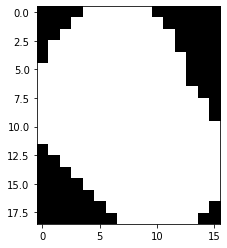

In [79]:
tma_id = "tma1"
patient_id = "E0003B_v1"
patch_id = "59"
cell_id = "4"

tma5_file = cell_hdf5_map[tma_id]
cell_data = tma5_file[tma_id][patient_id][patch_id][cell_id][cell_id]
cell_npy = np.zeros(cell_data.shape)
cell_data.read_direct(cell_npy)
plt.imshow(cell_npy, cmap='gray')

In [80]:
img = binary_fill_holes(cell_npy)
mask = img.copy()
img = img.astype(np.uint8)
img[mask] = 255

ret, thresh = cv2.threshold(img, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

[[[ 4  0]]

 [[ 1  3]]

 [[ 1  4]]

 [[ 0  5]]

 [[ 0 11]]

 [[ 7 18]]

 [[13 18]]

 [[15 16]]

 [[15 10]]

 [[14  9]]

 [[14  8]]

 [[12  6]]

 [[12  4]]

 [[11  3]]

 [[11  2]]

 [[ 9  0]]]
Rectangle center: (8.25, 9.249999046325684)
Rectangle width: 19.091881, height: 14.142135
Rectangle rotation angle: 45.0


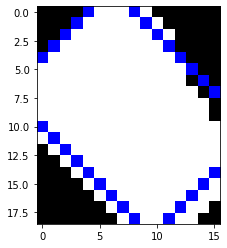

In [81]:
print(cnt)
rect = cv2.minAreaRect(cnt)
(rectCoord1, rectCoord2, rotate_angle) = rect
box = cv2.boxPoints(rect)
box = np.int0(box)

rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img,[box],0,(0,0,255),1)
plt.imshow(rgb_img)

print("Rectangle center:", rect[0])
print("Rectangle width: %.6f, height: %.6f" % (rect[1][0], rect[1][1]))
print("Rectangle rotation angle:", rect[2])